### Joshua Koonce
# Bank Churn Prediction
## Artificial Neural Networks Project

The objective of this project is to create an Artificial Neural Network that can predict if a customer will churn in the next 6 months or not.

The project will use a dataset from Kaggle that contains 10,000 samples and 14 features.

#### Data Dictionary:

- CustomerId: Unique ID, won't be used
- Surname: Last name
- CreditScore: Defines the credit history of the customer  
- Geography: Customer’s location    
- Gender: Defines the Gender of the customer   
- Age: Age of the customer     
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: Refers to the number of products that a customer has purchased through the bank
- Balance: Account balance
- HasCrCard: Categorical variable. Whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary 
- isActiveMember: Categorical variable that tells whether the customer is an active member
- Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. 1=Yes (Customer left the bank)

This is just a control variable that I use to enable/disable some functions while iterating through modeling to speed up the process.

In [1]:
speedy = False # DEBUG

Import the staple data science libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('white')

# Set the random seed for reproducibility
import random
seed = 1337
random.seed(seed)
np.random.seed(seed)

# Data Pre-Processing and Cleaning

Import the dataset under the name 'churn'

In [3]:
churn = pd.read_csv('bank.csv')

In [4]:
churn.shape

(10000, 14)

Confirms 10,000 rows of data and 14 features. Let's look at the layout:

In [5]:
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
pd.DataFrame([churn.dtypes, churn.count()], index=['type', 'count']).T

,type,count
RowNumber,int64,10000
CustomerId,int64,10000
Surname,object,10000
CreditScore,int64,10000
Geography,object,10000
Gender,object,10000
Age,int64,10000
Tenure,int64,10000
Balance,float64,10000
NumOfProducts,int64,10000


There are no missing values, but there may be invalid values within the dataframe such as duplicates.

The categorical values are currently the 'object' datatype, converting to category data types just to make things easier on the software.

In [7]:
if churn[churn.duplicated()].empty: 
    print('No duplicates.') 
else:
    churn[churn.duplicated()]

No duplicates.


It doesn't look like there are any completely duplicated rows.

In [8]:
churn.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Drop the RowNumber, CustomerId, and Surnames. These are categorical but have no meaning to the model, and won't assist in the analysis.

In [9]:
churn.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Take a look at the categorical labels to see if we have anything strange going on.

In [10]:
churn['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [11]:
churn['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

The unique values look good. We will turn these into dummy variables later.

In [12]:
churn['Geography'] = churn['Geography'].map({'France': 0, 'Germany': 1, 'Spain': 2})

In [13]:
churn['Gender'] = churn['Gender'].map({'Male': 0, 'Female': 1})

# Exploratory Data Analysis and Data Preprocessing


Overall descriptive statistics:

In [14]:
churn.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.746300,0.454300,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.827529,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,0.000000,0.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Let's look at the statistics for those that churned:

In [15]:
churn[churn['Exited'] == 1].describe(percentiles=[.5])

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.0
mean,645.351497,0.805106,0.559156,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531,1.0
std,100.321503,0.750123,0.496610,9.761562,2.936106,58360.794816,0.801521,0.458776,0.480358,57912.418071,0.0
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,1.0
50%,646.000000,1.000000,1.000000,45.000000,5.000000,109349.290000,1.000000,1.000000,0.000000,102460.840000,1.0
max,850.000000,2.000000,1.000000,84.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199808.100000,1.0


The average profile for a customer that churns can be seen above.

### Univariate Distributions EDA

In [16]:
## Define a function to plot all variables distributions, and if possible, a boxplot to show outliers and skew

def plot_uv(df, column):
    print('\tUnivariate Analysis: ', col)
    
    if df[column].dtypes.name != 'category':
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

        # assigning a graph to each axis
        sns.boxplot(x=df[column], ax=ax_box)
        sns.histplot(data=df, x=column, ax=ax_hist)

        # Remove x axis name for the boxplot
        ax_box.set(xlabel='')
        plt.show()
    else:
        sns.histplot(data=df, x=column)
        plt.show()

	Univariate Analysis:  CreditScore


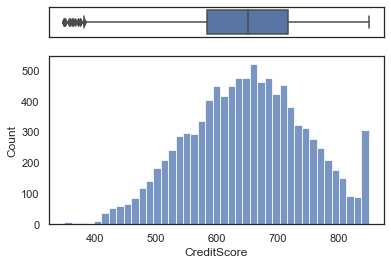

	Univariate Analysis:  Geography


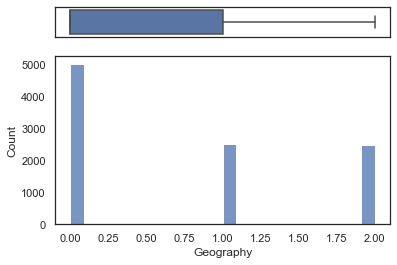

	Univariate Analysis:  Gender


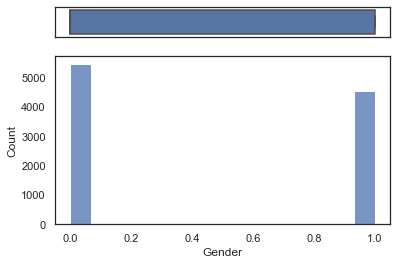

	Univariate Analysis:  Age


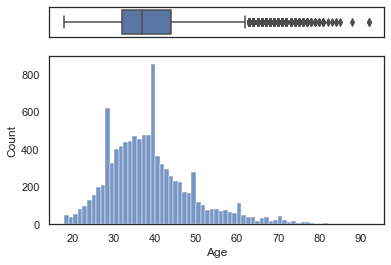

	Univariate Analysis:  Tenure


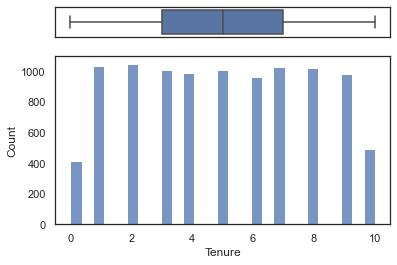

	Univariate Analysis:  Balance


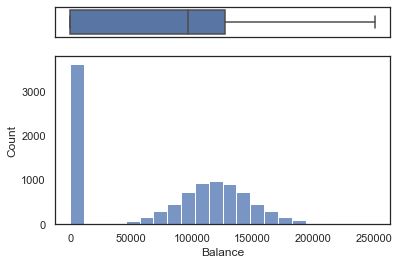

	Univariate Analysis:  NumOfProducts


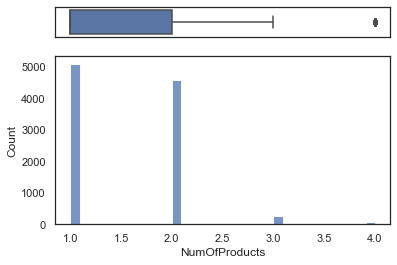

	Univariate Analysis:  HasCrCard


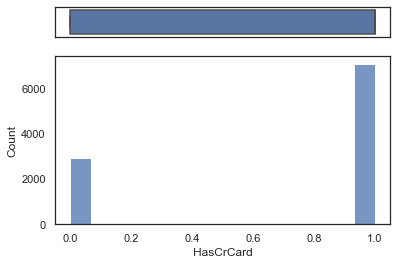

	Univariate Analysis:  IsActiveMember


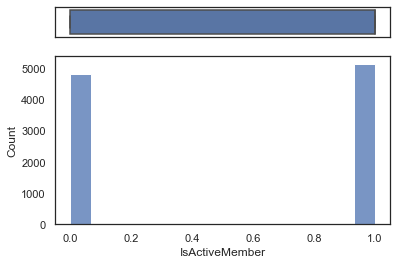

	Univariate Analysis:  EstimatedSalary


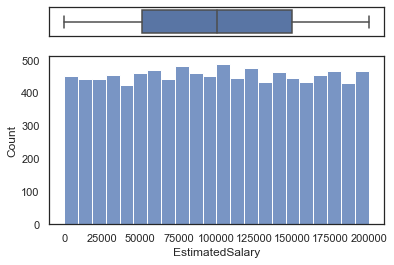

	Univariate Analysis:  Exited


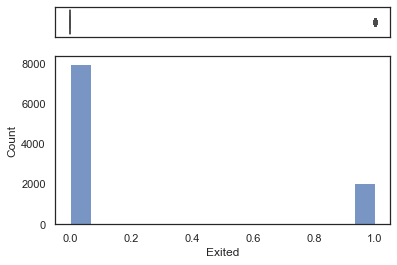

In [17]:
if not speedy:
    for col in churn.columns:
        plot_uv(churn, col)

The target variable, Exited, has some class imbalance. There are significantly less people that churn. This is somewhat expected, and we can attack this with stratification and/or resampling.

### Bi-variate EDA

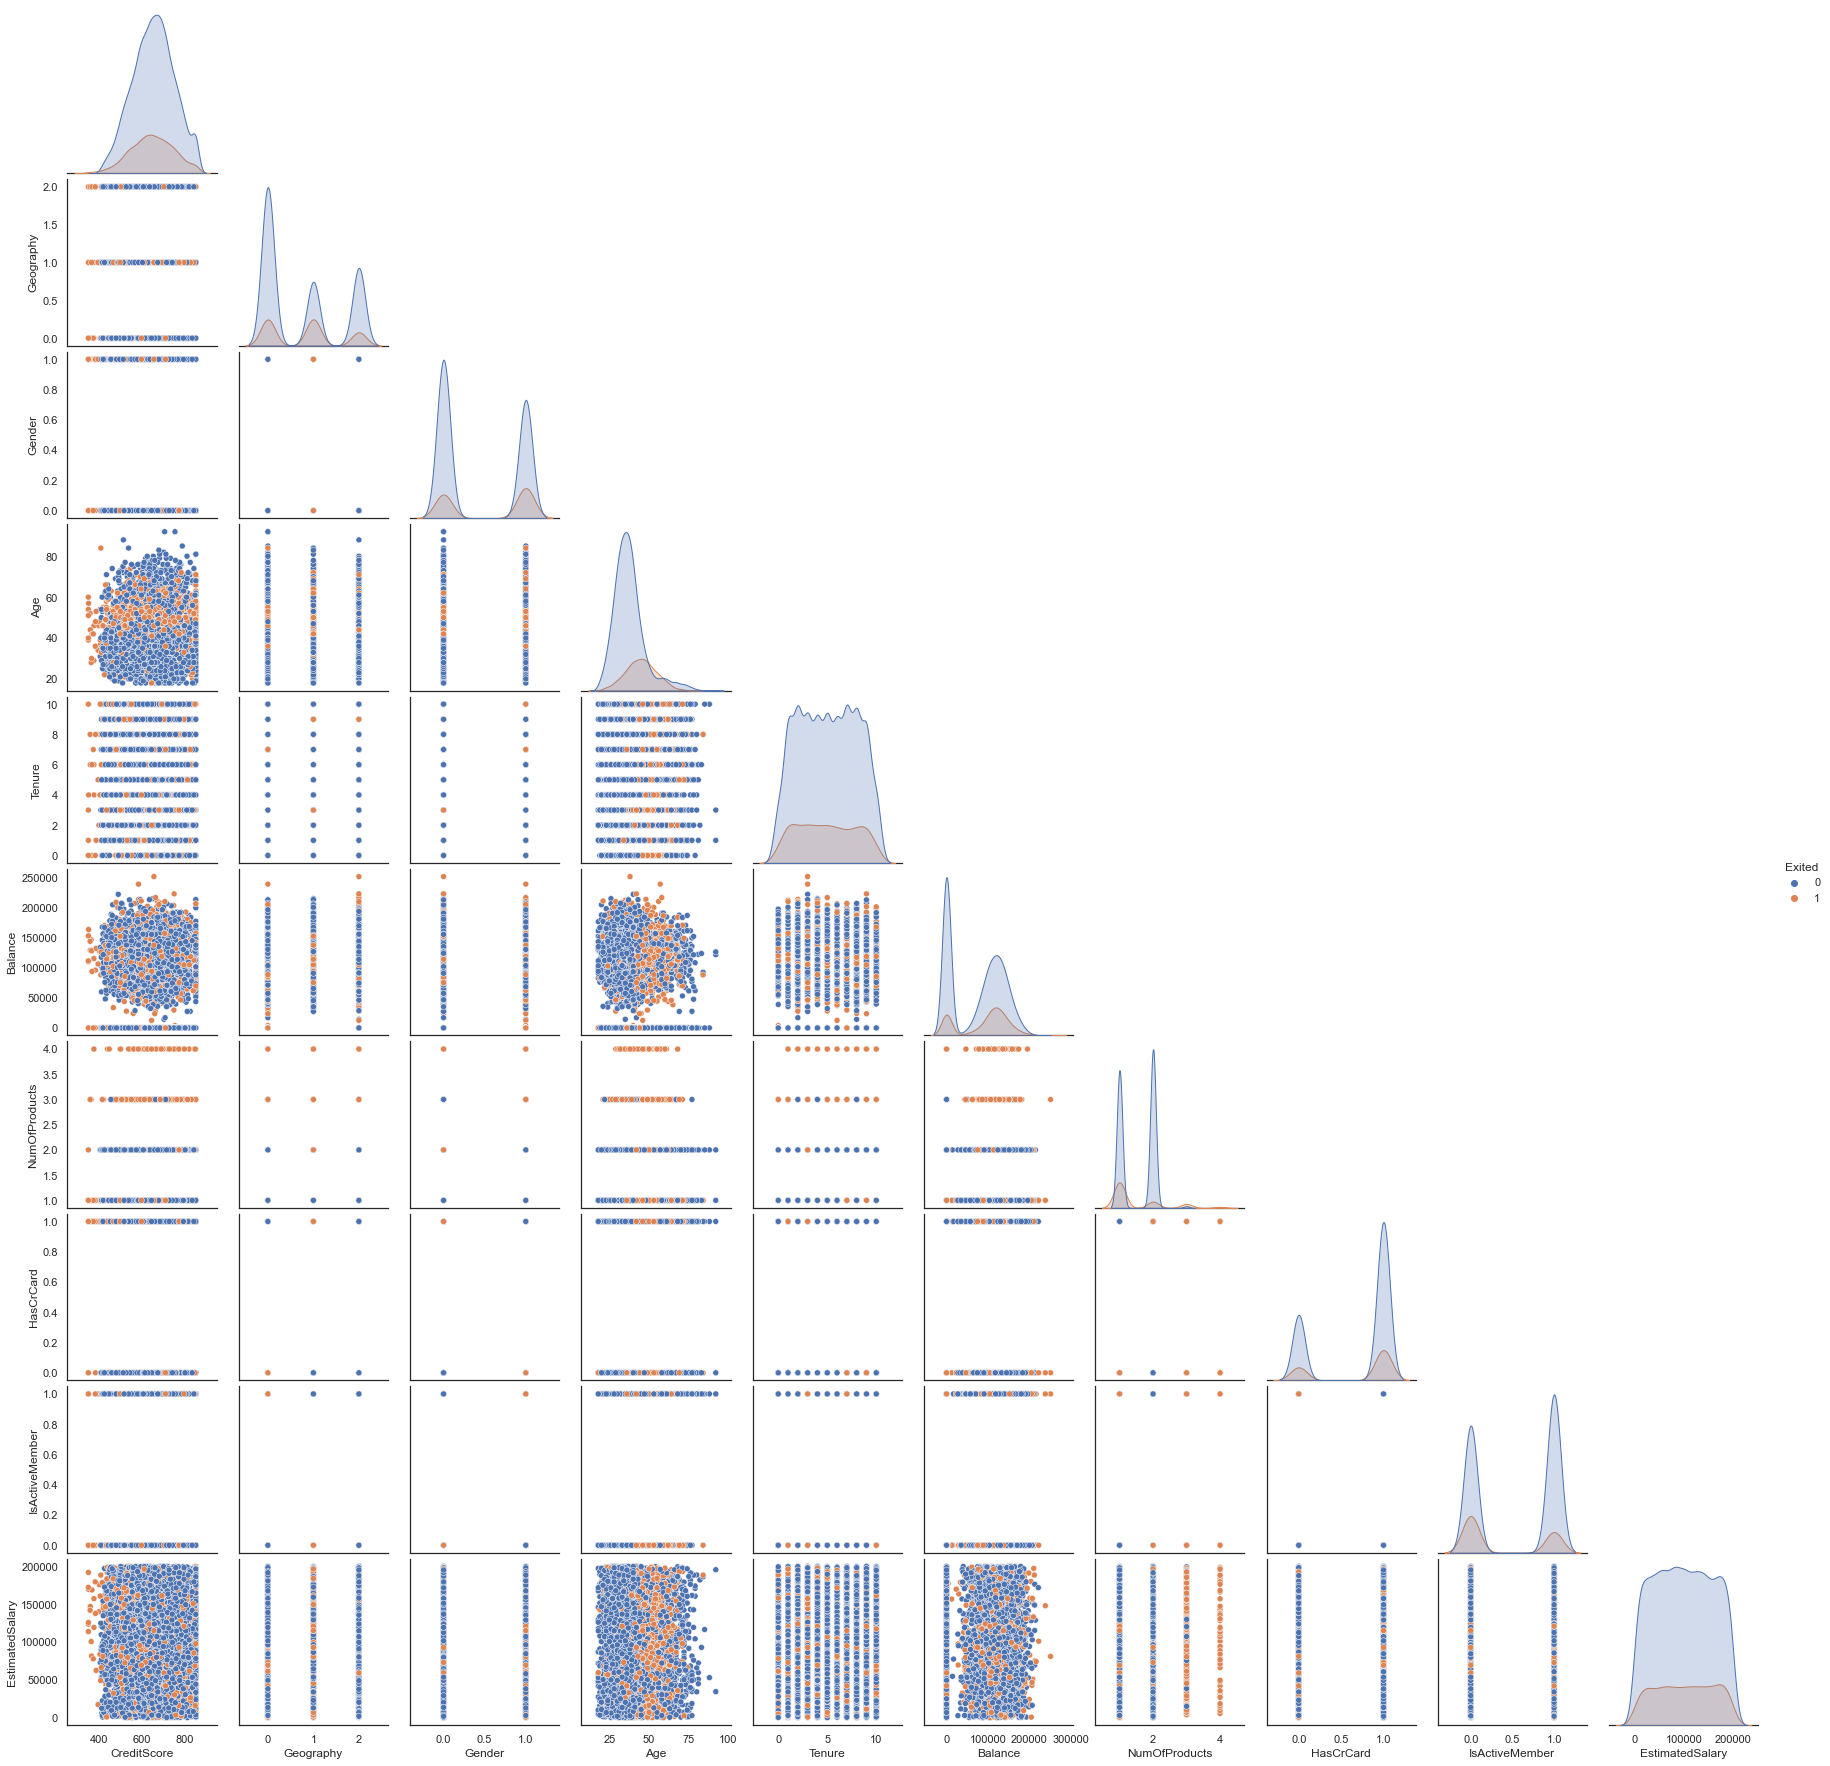

In [18]:
if not speedy:
    sns.pairplot(churn, corner=True, hue='Exited');

In [19]:
churn.corr()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.007888,0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Geography,0.007888,1.000000,-0.004719,0.022812,0.003739,0.069408,0.003972,-0.008523,0.006724,-0.001369,0.035943
Gender,0.002857,-0.004719,1.000000,0.027544,-0.014733,-0.012087,0.021859,-0.005766,-0.022544,0.008112,0.106512
Age,-0.003965,0.022812,0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,0.003739,-0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.069408,-0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,0.003972,0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.008523,-0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.006724,-0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.001369,0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


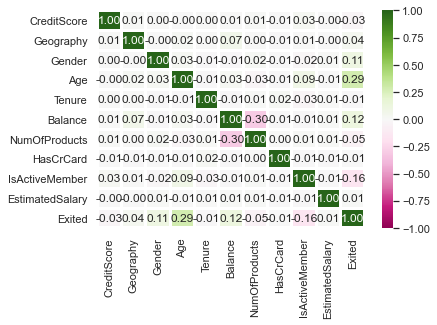

In [20]:
if not speedy:
    sns.heatmap(churn.corr(), vmin=-1, vmax=1, linewidths=2, annot=True, fmt='.2f', cmap='PiYG');

Dropping features that are not moving with Exited (virtually uncorrelated).

In [21]:
churn.drop(['CreditScore', 'Tenure', 'HasCrCard', 'EstimatedSalary'], axis=1, inplace=True)

In [22]:
churn.columns

Index(['Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'Exited'],
      dtype='object')

## Test/Train Split

Turn categorical columns into dummy variables:

In [23]:
churn = pd.get_dummies(churn, columns=['Gender', 'IsActiveMember'])

In [24]:
from sklearn.model_selection import train_test_split

Implement the splitout of the data:

In [25]:
x = churn.drop(['Exited'], axis=1)
y = churn['Exited'].astype(int)


# Create a holdout dataset to split into train/test, set 30% aside for final test
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=.3, random_state=seed)

# Check the lengths of each set to ensure it worked
[x.shape for x in [x,y, x_train, x_test, y_train, y_test]]

[(10000, 8), (10000,), (7000, 8), (3000, 8), (7000,), (3000,)]

## Data Standardization

Each split out set will need to be standardized separately to prevent the algorithm from getting 'leaked' information from the scaling of the whole dataframe.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [27]:
scaler = MinMaxScaler()

Note: The MinMaxScaler provided superior results over the other scalers with testing.

In [28]:
scaler.fit(x_train, y_train)

x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

Take a look at the dataframes to see how the data was changed:

In [29]:
x_train.head()

,Geography,Age,Balance,NumOfProducts,Gender_0,Gender_1,IsActiveMember_0,IsActiveMember_1
0,1.0,0.270270,0.000000,0.333333,0.0,1.0,0.0,1.0
1,0.0,0.351351,0.252847,0.000000,1.0,0.0,1.0,0.0
2,0.5,0.040541,0.533979,0.333333,1.0,0.0,1.0,0.0
3,1.0,0.243243,0.000000,0.333333,1.0,0.0,0.0,1.0
4,1.0,0.202703,0.000000,0.333333,1.0,0.0,0.0,1.0


In [30]:
x_test.head()

,Geography,Age,Balance,NumOfProducts,Gender_0,Gender_1,IsActiveMember_0,IsActiveMember_1
0,0.0,0.243243,0.332977,0.000000,1.0,0.0,1.0,0.0
1,0.0,0.270270,0.414875,0.000000,0.0,1.0,1.0,0.0
2,1.0,0.189189,0.183984,0.000000,1.0,0.0,0.0,1.0
3,0.0,0.229730,0.000000,0.333333,1.0,0.0,1.0,0.0
4,0.5,0.202703,0.539304,0.333333,1.0,0.0,0.0,1.0


In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 8)
(7000,)
(3000, 8)
(3000,)


Calculate target class weights for use in modeling:

In [32]:
class_weights = { 0: sum(y_train == 0) / len(y_train), 1: sum(y_train == 1) / len(y_train) }
class_weights

{0: 0.7962857142857143, 1: 0.2037142857142857}

## Under/Oversampling Attempt

I attempted to both under and oversample the dataset and it performed worse than the original dataset with the class imbalance. Leaving the code here to illustrate what was done.

In [33]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Oversample:

In [34]:
sm = SMOTE(k_neighbors=5, random_state=seed)

x_train_os, y_train_os = sm.fit_resample(x_train, y_train)

Undersample:

In [35]:
rus = RandomUnderSampler(random_state=1337)

x_train_us, y_train_us = rus.fit_resample(x_train, y_train)

See the results:

In [36]:
print(f'Shape of oversampled data: {x_train_os.shape}')
print(f'Label 1: {sum(y_train_os==1)}')
print(f'Label 0: {sum(y_train_os==0)}')

print(f'\nShape of undersampled data: {x_train_us.shape}')
print(f'Label 1: {sum(y_train_us==1)}')
print(f'Label 0: {sum(y_train_us==0)}')

Shape of oversampled data: (11148, 8)
Label 1: 5574
Label 0: 5574

Shape of undersampled data: (2852, 8)
Label 1: 1426
Label 0: 1426


## Setup Metrics and Plotting Functions

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix 

In [38]:
results = {}

In [39]:
def Plot_ROC(y_test, model_probs):
    random_probs = [0 for _ in range(len(y_test))]
   
    model_auc = roc_auc_score(y_test, model_probs)
   
    random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
       
    plt.figure()

    plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
    plt.plot(model_fpr, model_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')
   
    plt.legend()
    plt.show()
    
    print('Model: ROC AUC=%.2f' % (model_auc))


In [40]:
def Model_Metrics(fit_model, decision_threshold, train_targets, test_targets):
    '''Draws plentiful metrics when provided the model, the classification decision threshold for a 
    positive, and the targets for train and test data.'''
    
    ### Calculate Predictions based on Model
    y_hat = fit_model.model.predict(x_test)
    y_hat_train = fit_model.model.predict(x_train)
    
    y_hat = (y_hat > decision_threshold).round(0).astype(int)
    y_hat_train = (y_hat_train > decision_threshold).round(0).astype(int)
    
    ### Confusion Matrix and Classification Metrics
    scores = []
    
    train_acc = round(accuracy_score(train_targets, y_hat_train), ndigits=2)
    train_rec = round(recall_score(train_targets, y_hat_train), ndigits=2)
    train_f1 = round(f1_score(train_targets, y_hat_train), ndigits=2)

    print("Training Set Metrics: ")
    print('Accuracy: ', train_acc)
    print('Recall: ', train_rec)
    print('F1: ', train_f1)
    
    test_acc = round(accuracy_score(test_targets, y_hat), ndigits=2)
    test_rec = round(recall_score(test_targets, y_hat), ndigits=2)
    test_f1 = round(f1_score(test_targets, y_hat), ndigits=2)

    scores.extend((test_acc, test_rec, test_f1))

    print("\nTest Set Metrics: ")
    print('Accuracy: ', test_acc)
    print('Recall: ', test_rec)
    print('F1: ', test_f1)
    
    # create the confusion matrix
    conf_matrix = confusion_matrix(test_targets, y_hat)
   
    # print the heatmap with some indicator printouts since sklearn does its confusion matrix backwards
    print("\nConfusion Matrix for Test Metrics")
    print('\t\tTN\t\tFP\n')
    print('\t\tFN\t\tTP')
    
    plt.figure()
    
    # create the heatmap display
    heatmap = sns.heatmap(conf_matrix, cmap='magma', annot=True, fmt='d');
    heatmap.set_ylabel('actual')
    heatmap.set_xlabel('prediction')
    heatmap.plot()
    
        ### Get accuracy and loss metrics from the model
    bin_acc = fit_model.history['binary_accuracy']
    val_bin_acc = fit_model.history['val_binary_accuracy']
    loss = fit_model.history['loss']
    val_loss = fit_model.history['val_loss']
    
    ### Number of epochs run helps draw the charts
    epochs = range(1, len(bin_acc) + 1)
    
       
    ### Plot Accuracy
    
    plt.figure()
    
    plt.plot(epochs, bin_acc, 'b', label="Training Accuracy")
    plt.plot(epochs, val_bin_acc, 'r', label="Validation Accuracy")
    plt.title("Training/Validation Accuracy")
    plt.legend(loc='lower right')
    plt.xlabel("epochs")

    plt.figure()

    ### Plot Loss
    plt.plot(epochs, loss, 'b', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label="Validation Loss")
    plt.title("Training/Validation Loss")
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.ylim(min(min(loss), min(val_loss), max(max(loss), max(val_loss))))
    
    return scores

## Model Building

For this business problem, I will use the Recall score as my primary metric of interest.

In my opinion, we need to positively identify customers who are likely to churn so that we can see where our business is least successful. We can focus less on those customers OR we can modify our offerings to suit the needs of that class of customer if the model is successful. 

Recall focuses on true positives identified out of total actual positives, in this case a "positive" is churn.

In [41]:
import keras
import tensorflow as tf 
import os

tf.random.set_seed(seed)
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # this keeps TF from using the GPU to compute,if necessary

List the GPUs available to Tensorflow: 

In [42]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Import the necessary features of Keras/TF, to include the model itself, the ability to create layers, optimizers, and callbacks for early termination.

In [43]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping

### Initial Model

Modeling with class weights and a 6 neuron hidden layer.

In [44]:
model_initial = Sequential() # Sequential model (tensors flow in one direction, other models can go back to previous layers as well)

# Define loss, optimizer, and metric
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=.01)
metric = keras.metrics.BinaryAccuracy()

# Input layer n = number of features
# Hidden layers, 1-2 layers of nodes with number of nodes mean between input/output node count
# Output layer n for binary = sigmoid with n = 1
model_initial.add(layers.Input(len(x_train.columns), name='Input'))
model_initial.add(layers.Dense(np.ceil(len(x_train.columns) * .75), activation='relu', name='CrouchingTiger'))
model_initial.add(layers.Dense(1, activation='sigmoid', name='Output'))

# Compile the model
model_initial.compile(loss=loss, optimizer=optimizer, metrics=metric) 

# Summarize the model
model_initial.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CrouchingTiger (Dense)       (None, 6)                 54        
_________________________________________________________________
Output (Dense)               (None, 1)                 7         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Training Set Metrics: 
Accuracy:  0.78
Recall:  0.46
F1:  0.46

Test Set Metrics: 
Accuracy:  0.79
Recall:  0.49
F1:  0.49

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


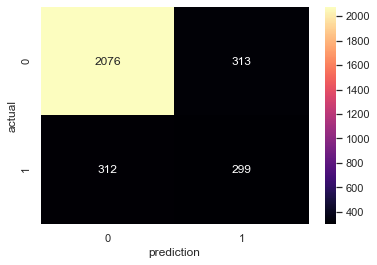

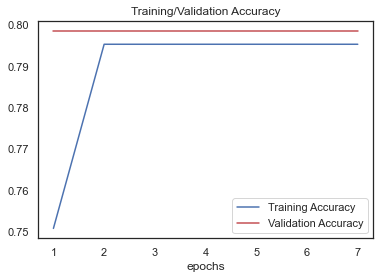

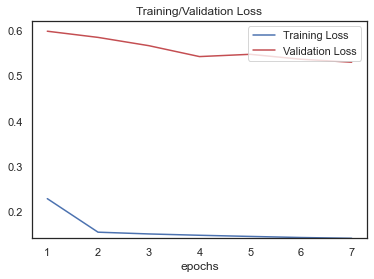

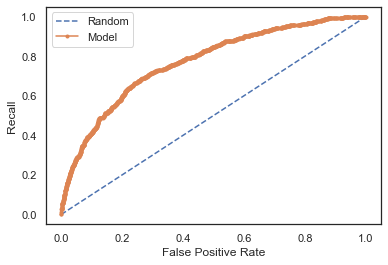

Model: ROC AUC=0.77
Wall time: 5.29 s


In [45]:
%%time

# Fit the model with desired parameters
model_initial = model_initial.fit(x_train, y_train, 
                                  class_weight=class_weights,
                                  validation_split=0.3, 
                                  verbose=False,
                                  epochs=100,
                                  callbacks=[EarlyStopping(monitor='binary_accuracy', patience=5)])

# Show metrics
result = Model_Metrics(model_initial, .1, y_train, y_test);
Plot_ROC(y_test, model_initial.model.predict(x_test))
results['Initial Model'] = result

In the initial model I used class weights to try and address class imbalance. It turned out to not be helpful with this particular dataset. The initial model yielded a good Accuracy but an unacceptable Recall.

### Oversampled Model

In [46]:
model_os = Sequential() # Sequential model (tensors flow in one direction, other models can go back to previous layers as well)

# Define loss, optimizer, and metric
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=.01)
metric = keras.metrics.BinaryAccuracy()

# Input layer n = number of features
# Hidden layers, 1-2 layers of nodes with number of nodes mean between input/output node count
# Output layer n for binary = sigmoid with n = 1
model_os.add(layers.Input(len(x_train.columns), name='Input'))
model_os.add(layers.Dense(np.ceil(len(x_train.columns) * .75), activation='relu', name='CrouchingTiger'))
model_os.add(layers.Dense(1, activation='sigmoid', name='Output'))

# Compile the model
model_os.compile(loss=loss, optimizer=optimizer, metrics=metric) 

# Summarize the model
model_os.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CrouchingTiger (Dense)       (None, 6)                 54        
_________________________________________________________________
Output (Dense)               (None, 1)                 7         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Training Set Metrics: 
Accuracy:  0.78
Recall:  0.68
F1:  0.55

Test Set Metrics: 
Accuracy:  0.79
Recall:  0.69
F1:  0.58

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


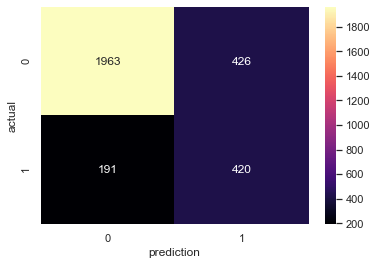

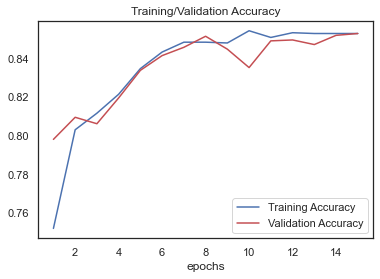

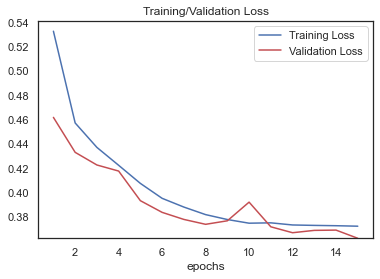

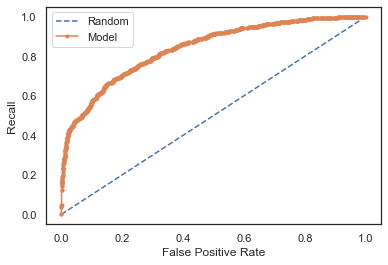

Model: ROC AUC=0.84
Wall time: 7.4 s


In [47]:
%%time

# Fit the model with desired parameters
model_os = model_os.fit(x_train, y_train, 
                                  validation_split=0.3, 
                                  verbose=False,
                                  epochs=100,
                                  callbacks=[EarlyStopping(monitor='binary_accuracy', patience=5)])

# Show metrics
result = Model_Metrics(model_os, .2, y_train, y_test);
Plot_ROC(y_test, model_os.model.predict(x_test))
results['Oversampled Model'] = result

I dropped class weighting which improved results dramatically. Oversampling resulted in much better Recall, but more room for improvement. Accuracy remained relatively stable.

### Undersampled Model

In [48]:
model_us = Sequential() # Sequential model (tensors flow in one direction, other models can go back to previous layers as well)

# Define loss, optimizer, and metric
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=.01)
metric = keras.metrics.BinaryAccuracy()

# Input layer n = number of features
# Hidden layers, 1-2 layers of nodes with number of nodes mean between input/output node count
# Output layer n for binary = sigmoid with n = 1
model_us.add(layers.Input(len(x_train.columns), name='Input'))
model_us.add(layers.Dense(np.ceil(len(x_train.columns) * .75), activation='relu', name='CrouchingTiger'))
model_us.add(layers.Dense(1, activation='sigmoid', name='Output'))

# Compile the model
model_us.compile(loss=loss, optimizer=optimizer, metrics=metric) 

# Summarize the model
model_us.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CrouchingTiger (Dense)       (None, 6)                 54        
_________________________________________________________________
Output (Dense)               (None, 1)                 7         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Training Set Metrics: 
Accuracy:  0.71
Recall:  0.7
F1:  0.5

Test Set Metrics: 
Accuracy:  0.74
Recall:  0.72
F1:  0.53

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


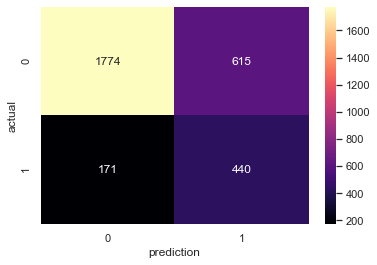

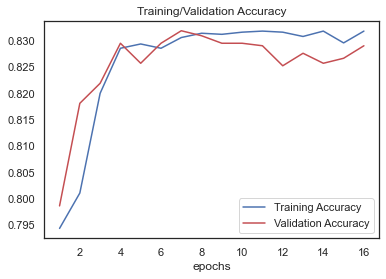

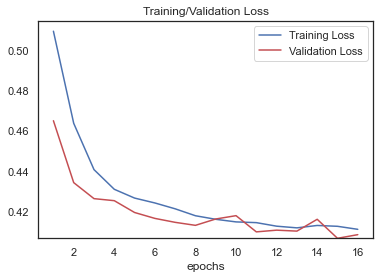

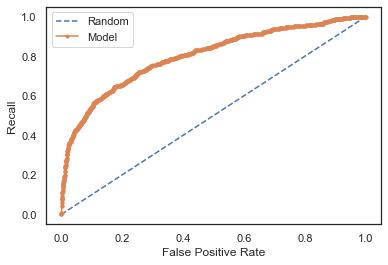

Model: ROC AUC=0.80
Wall time: 7.84 s


In [49]:
%%time

# Fit the model with desired parameters
model_us = model_us.fit(x_train, y_train, 
                                  validation_split=0.3, 
                                  verbose=False,
                                  epochs=100,
                                  callbacks=[EarlyStopping(monitor='binary_accuracy', patience=5)])

# Show metrics
result = Model_Metrics(model_us, .2, y_train, y_test);
Plot_ROC(y_test, model_us.model.predict(x_test))
results['Undersampled Model'] = result

The undersampled model yielded similar results, but slightly lower Accuracy and higher Recall.

### Final Model

Model training with no class weights:

In [50]:
model_final = Sequential() # Sequential model (tensors flow in one direction, other models can go back to previous layers as well)

# Define loss, optimizer, and metric
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=.01)
metric = keras.metrics.BinaryAccuracy()

# Input layer n = number of features
# Hidden layers, 1-2 layers of nodes with number of nodes mean between input/output node count
# Output layer n for binary = sigmoid with n = 1
model_final.add(layers.Input(len(x_train.columns), name='Input'))
model_final.add(layers.Dense(np.ceil(len(x_train.columns) * .75), activation='relu', name='CrouchingTiger'))
model_final.add(layers.Dense(np.ceil(len(x_train.columns) * .75), activation='relu', name='HiddenDragon'))
model_final.add(layers.Dense(1, activation='sigmoid', name='Output'))

# Compile the model
model_final.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Summarize the model
model_final.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CrouchingTiger (Dense)       (None, 6)                 54        
_________________________________________________________________
HiddenDragon (Dense)         (None, 6)                 42        
_________________________________________________________________
Output (Dense)               (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


Training Set Metrics: 
Accuracy:  0.76
Recall:  0.76
F1:  0.57

Test Set Metrics: 
Accuracy:  0.78
Recall:  0.77
F1:  0.59

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


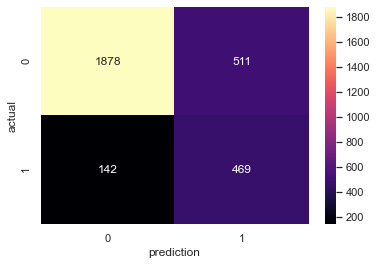

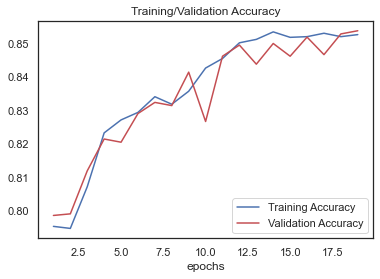

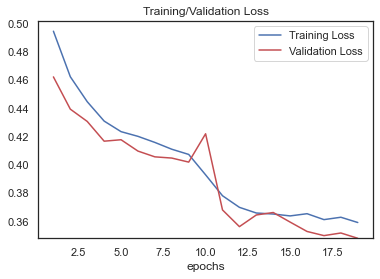

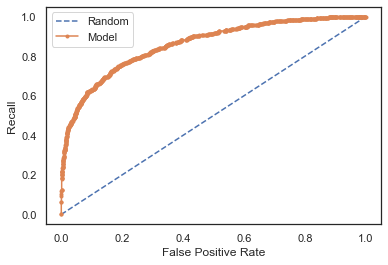

Model: ROC AUC=0.86
Wall time: 9.77 s


In [51]:
%%time

# Fit the model with desired parameters
model_final = model_final.fit(x_train, y_train, 
                              validation_split=0.3,
                              class_weight=None,
                              verbose=False,
                              epochs=100, 
                              callbacks=[EarlyStopping(monitor='binary_accuracy', patience=5)])

# Show metrics
result = Model_Metrics(model_final, .2, y_train, y_test);
Plot_ROC(y_test, model_final.model.predict(x_test))
results['Final Model'] = result

The final model achieved the best results. I didn't use under/oversampling but added a second layer. This seems to have helped this model but did not help models prior.

#### Summary of Results

In [52]:
pd.DataFrame(data=results, index=['Accuracy', 'Recall', 'F1']).T

,Accuracy,Recall,F1
Initial Model,0.79,0.49,0.49
Oversampled Model,0.79,0.69,0.58
Undersampled Model,0.74,0.72,0.53
Final Model,0.78,0.77,0.59


For layer building, I used a rule of thumb that the hidden layer neuron count should be around 3/4 of the input nodes. I built 1 hidden layer for the first three models and 2 layers for the last.

I used a lower threshold than 50% to determine if a customer may churn, based off the ROC_AUC curve, because I'd rather take preventive action on a customer that wouldn't have churned than to risk taking no action on a customer that would churn if not intervened upon (Recall is more important). The ROC curve indicates the threshold should be about .2 to optimize between Recall and False Positives.

This achieved a solid accuracy and the best recall of the networks.

### Conclusion and Key Takeaways

Using the ANN, and taking a look at the ROC curve, we have achieved a much better ability to forecast churn than random guessing would accomplish.

Whereas we had no ability to forecast if a customer would churn prior to the modeling, we now have the ability to predict churn at a reasonable rate.

We will end up using retention efforts on many customers who were not going to churn (False Positives), but we have minimized failing to use retention efforts on customers who would churn (False Negatives) greatly.

Overall, the business should be much more proficient at retaining customers.